<a href="https://colab.research.google.com/github/coho905/Machine-Learning-Projects/blob/main/UnderstandingSiri2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Voice Commands

For voice commands, Siri needs to be able to figure out *what* the speaker wants, and then *how* to accomplish that request. 

<img src="https://www.cheatsheet.com/wp-content/uploads/2016/01/Siri-in-iOS-9-640x305.png" width=400>

The focus of this notebook is predicting the 'what', in other words, the **intent** of a voice command.

Remember that this is part (a) of our two-part goal.

---

In this notebook we'll be:
*   Preprocessing the Dataset for the ML models
*   Implementing a Pretrained BERT model

## Sentence Level Classification




Here is where our friend BERT comes in to help us. As a reminder, **BERT** stands for **B**idirectional **E**ncoder **R**epresentations from **T**ransformers, and is a novel model architecture that uses both the left and right *context* words in a sequence to generate good embeddings for words. 

We can make use of existing Pytorch APIs for BERT that will allow us to convert our voice command sequence data into the format that the BERT model expects, and then use *pretrained* BERT for our classification task.

<img src="https://pytorch.org/tutorials/_images/bert.png" height="300">

Note that there are many available pretrained BERT models with varying attributes such as: the language of the corpus for training, how many layers and attention heads are used, if the corpus for pretraining contains uncased or cased words, and so on. We will use the cased BERT base, which is the architecture described in the slides (12 layers - 6 layers within the encoder and 6 layers within the decoder - and 12 attention heads), and is trained on cased English text.





**IMPORTANT**: Since the BERT model we will be using in this notebook is so large, we need to do one step before continuing. Please go to the 'Runtime' tab, and click on 'Change Runtime Type'; then select **GPU** under the dropdown for Hardware accelerator.

In [ ]:
#@title Run this code to get started
%tensorflow_version 2.x
%pip install -q transformers

from urllib.request import urlretrieve
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# SNIPS_DATA_BASE_URL = (
#     "https://github.com/ogrisel/slot_filling_and_intent_detection_of_SLU/blob/"
#     "master/data/snips/"
# )
# for filename in ["train", "valid", "test", "vocab.intent", "vocab.slot"]:
#     path = Path(filename)
#     if not path.exists():
#       print(f"Downloading {filename}...")
#       urlretrieve(SNIPS_DATA_BASE_URL + filename + "?raw=true", path)

!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Siri%20(Bert)%20Voice%20Commands/train'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Siri%20(Bert)%20Voice%20Commands/valid'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Siri%20(Bert)%20Voice%20Commands/test'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Siri%20(Bert)%20Voice%20Commands/vocab.intent'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Siri%20(Bert)%20Voice%20Commands/vocab.slot'



def parse_line(line):
    data, intent_label = line.split(" <=> ")
    items = data.split()
    words = [item.rsplit(":", 1)[0]for item in items]
    word_labels = [item.rsplit(":", 1)[1]for item in items]
    return {
        "intent_label": intent_label, ### YOUR CODE HERE ###, 
        "words": " ".join(words),
        "word_labels": " ".join(word_labels), ### YOUR CODE HERE ###,
        "length": len(words), ### YOUR CODE HERE ###,
    }


train_lines = Path("train").read_text().strip().splitlines()
valid_lines = Path("valid").read_text().strip().splitlines()
test_lines = Path("test").read_text().strip().splitlines()

df_train = pd.DataFrame([parse_line(line) for line in train_lines])
df_valid = pd.DataFrame([parse_line(line) for line in valid_lines])
df_test = pd.DataFrame([parse_line(line) for line in test_lines])

     |████████████████████████████████| 2.5MB 26.5MB/s 
     |████████████████████████████████| 901kB 47.8MB/s 
     |████████████████████████████████| 3.3MB 47.6MB/s 
--2021-07-03 16:22:52--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Siri%20(Bert)%20Voice%20Commands/train
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.80, 172.217.13.240, 172.217.15.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1793794 (1.7M) [application/octet-stream]
Saving to: ‘train’

train               100%[===================>]   1.71M  --.-KB/s    in 0.009s  

2021-07-03 16:22:52 (196 MB/s) - ‘train’ saved [1793794/1793794]

--2021-07-03 16:22:52--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Siri%20(Bert)%20Voice%2

Remember that `df_train`, `df_valid`, and `df_test` are the Pandas Dataframes that store our training, validation, and test datapoints.

### Step 1: Tokenize our Data

BERT expects input sequences to be broken down into individual *tokens*; a `[CLS]` token marks the beginning and a `[SEP]` marks the end of a given sequence (as seen in the red input sentences in the image above).

The `[CLS]` token is used by BERT for the pre-training task for sequence classification.

The `[SEP]` token is a separator for the pre-training task that classifies if a pair of sentences are consecutive in a corpus or not, i.e. next sentence prediction (NSP).

In [ ]:
# Import the BERT tokenizer and utilize the BERT base pretrained model
from transformers import BertTokenizer

model_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

How many unique tokens in this BERT model are there?

In [ ]:
tokenizer.vocab_size

28996

Wow - there's roughly 30k tokens that BERT knows! <img src="https://i7.pngguru.com/preview/625/201/218/emoji-iphone-computer-icons-clip-art-emoji-thumbnail.jpg" width=20>

Let's see exactly how the BERT tokenizer works on one training example.

In [ ]:
# Print the first training data sequence
first_sentence = df_train.iloc[0]["words"]
print(first_sentence)
print("This sentence contains {} words.".format(len(first_sentence.split(" "))))

Add Don and Sherri to my Meditate to Sounds of Nature playlist
This sentence contains 12 words.


In [ ]:
tokens = tokenizer.tokenize(first_sentence)
for t in tokens:
  print(t)
print("\nThis sentence turns into {} tokens.".format(len(tokens)))

Ad
##d
Don
and
She
##rri
to
my
Me
##dit
##ate
to
Sounds
of
Nature
play
##list

This sentence turns into 17 tokens.


Hmmm, why are there 17 *tokens* now but only 12 *words* within the original sequence.

It's because BERT uses something called subword tokenization!

**Subword tokenization** may break some words into smaller units and doesn't always use a 1:1 mapping of words to tokens. Because of subword tokenization within BERT, the length of tokenized sentences is likely to be larger than the original number of words in the sentence.

**Discuss:**

Why is it interesting and useful to use subword tokenization for generic language models such as BERT?

### Step 2: Encoding Tokens

Each token is mapped to a unique integer id that makes it fast to lookup the correct column in the input layer token embedding (seen in yellow below).

<img src="https://miro.medium.com/max/1496/1*fywysLzEbXxEqkPeIUWaJw.png" width="500">

In [ ]:
# See the first 10 (token,id) pairs within BERT.
bert_vocab_items = list(tokenizer.vocab.items())
bert_vocab_items[:10]

[('[PAD]', 0),
 ('[unused1]', 1),
 ('[unused2]', 2),
 ('[unused3]', 3),
 ('[unused4]', 4),
 ('[unused5]', 5),
 ('[unused6]', 6),
 ('[unused7]', 7),
 ('[unused8]', 8),
 ('[unused9]', 9)]

In [ ]:
# See more (token,id) examples within BERT's vocab.
bert_vocab_items[1100:1110]

[('－', 1100),
 ('／', 1101),
 ('：', 1102),
 ('the', 1103),
 ('of', 1104),
 ('and', 1105),
 ('to', 1106),
 ('in', 1107),
 ('was', 1108),
 ('The', 1109)]

In [ ]:
# Why are these tokens interesting?
bert_vocab_items[100:104]

[('[UNK]', 100), ('[CLS]', 101), ('[SEP]', 102), ('[MASK]', 103)]

(The `[UNK]` token is used to replace tokens that BERT doesn't recognize. If there is no way to split a word into subtokens, the whole word becomes `[UNK]`.)

`[CLS]` marks the beginning of a sentence, and `[SEP]` marks the end. 

`[MASK]` is used by BERT in the pre-training task called MLM (Masked Language Model) where it learns to predict the original word if it's masked out in a sentence.

Let's analyze the first training sequence again.

In [ ]:
# See the integer indexes for the token embeddings of the first sentence.
idxs = tokenizer.encode(first_sentence)
print(idxs)

[101, 24930, 1181, 1790, 1105, 1153, 14791, 1106, 1139, 2508, 17903, 2193, 1106, 10560, 1104, 7009, 1505, 7276, 102]


In [ ]:
# Decode the encoding, which should produce the original sequence.
tokenizer.decode(idxs)

'[CLS] Add Don and Sherri to my Meditate to Sounds of Nature playlist [SEP]'

### Step 3: Padding Tokenized Sequences

#### Exercise 1

In the Training Data Analysis section of the 1st notebook, we created a histogram according to the lengths of training sequences. Let's take a look at the histogram of the **tokenized** sequences now.

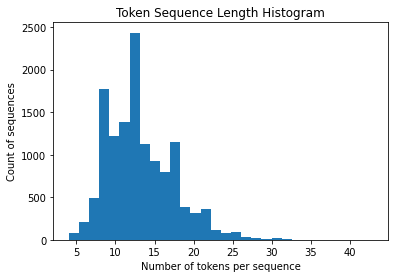

In [ ]:
# Print histogram of training tokenized sequence lengths.
# Hint: use tokenizer.encode on every sequence within df_train
# & get the lengths; then use plt.hist()

train_sequence_lengths = [len(tokenizer.encode(i)) for i in df_train['words']]
plt.hist(train_sequence_lengths, bins=30)
plt.xlabel("Number of tokens per sequence")
plt.ylabel("Count of sequences")
plt.title("Token Sequence Length Histogram")
plt.show()

What is the maximum length of any given tokenized training sequence?

*Remember that the maximum of the original voice command lengths was 35 words per sequence.*

In [ ]:
max_token_len = max(train_sequence_lengths)
print("Maximum tokenized sequence length: {} tokens per sequence".format(max_token_len))

Maximum tokenized sequence length: 43 tokens per sequence


**Transfer learning**, i.e. using *pretrained* BERT applied to our new dataset and sentiment classification task, requires that the sequences are **padded**, which means they all have the same length.

The above histogram shows that after tokenization, 43 tokens is long enough to represent all the voice commands in the training set.

### Preprocessing Full Dataset

<img src="https://miro.medium.com/max/2152/1*vNGH3DTu83pZr3gVHsz7yg.png" width=500>


Let's now encode the full train, validation, and test sets with the BERT tokenizer to get padded integer numpy arrays.

In [ ]:
def encode_dataset(text_sequences):
    # Create token_ids array (initialized to all zeros), where 
    # rows are a sequence and columns are encoding ids
    # of each token in given sequence.
    token_ids = np.zeros(shape=(len(text_sequences), max_token_len),
                         dtype=np.int32)
    
    for i, text_sequence in enumerate(text_sequences):
        encoded = tokenizer.encode(text_sequence)
        token_ids[i, 0:len(encoded)] = encoded

    attention_masks = (token_ids != 0).astype(np.int32)
    return {"input_ids": token_ids, "attention_masks": attention_masks}

In [ ]:
encoded_train = encode_dataset(df_train["words"])

Let's see what the output of the function `encode_dataset` is on the training data:

In [ ]:
encoded_train["input_ids"]

array([[  101, 24930,  1181, ...,     0,     0,     0],
       [  101,  1508,  1244, ...,     0,     0,     0],
       [  101,  5194,  1103, ...,     0,     0,     0],
       ...,
       [  101, 27640,  1116, ...,     0,     0,     0],
       [  101,  5979,  6608, ...,     0,     0,     0],
       [  101,  1327,  2523, ...,     0,     0,     0]], dtype=int32)

In [ ]:
encoded_train["attention_masks"]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)

**Discuss**:

What is the purpose of the attention_masks array?
(Hint: Think about what each row and column corresponds to).


#### Exercise 2

Let's also create the encoding id and attention mask arrays for the validation and test sets:

In [ ]:
# Create the necessary np arrays using the encode_dataset function
# and store your results in encoded_valid, and encoded_test.
encoded_valid = encode_dataset(df_valid["words"])
encoded_test = encode_dataset(df_test["words"])
### YOUR CODE HERE ###

#### Encoding the Sequence Classification Targets

Aside from encodings of the tokenized word sequences, we also need to get the encodings of the target intent classification labels.

In [ ]:
# Build a map from target intent label to a unique id.
intent_names = Path("vocab.intent").read_text().split()
intent_map = dict((label, idx) for idx, label in enumerate(intent_names))
intent_map

{'AddToPlaylist': 0,
 'BookRestaurant': 1,
 'GetWeather': 2,
 'PlayMusic': 3,
 'RateBook': 4,
 'SearchCreativeWork': 5,
 'SearchScreeningEvent': 6}

In [ ]:
# Convert list of target labels into their corresponding unique id.
intent_train = df_train["intent_label"].map(intent_map).values
intent_train

array([0, 0, 0, ..., 6, 6, 6])

In [ ]:
# Sanity check: the number of sentences that belongs to each class
for i in range(7):
  print(len(intent_train[intent_train == i]))

1842
1873
1900
1900
1856
1854
1859


<img src="https://drive.google.com/uc?id=1i9qommblASpRkuJWCtyRo2E1xYd7IgfA" height="200">

Great! This is the same as we found within the first notebook (screenshot of that output above).

##### Exercise 3

Lastly, we need to encode the intent labels for the validation and training sets as well.

In [ ]:
# Create two variables named intent_valid and intent_test
# Hint: look at how intent_train is defined a few cells above. 
intent_test = df_test["intent_label"].map(intent_map).values
intent_valid = df_valid["intent_label"].map(intent_map).values
### YOUR CODE HERE ###

### Using a Pretrained BERT model

Yay - we have all the pre-processing steps done! Now it's time to explore pretrained BERT. <img src="https://i.pinimg.com/originals/58/e9/78/58e97802c32da4c19d8429823c3201c2.jpg" width=25>

In [ ]:
from transformers import TFBertModel

# recall that we earlier defined model_name to be "bert-base-cased"
base_bert_model = TFBertModel.from_pretrained(model_name)
base_bert_model.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


Let's see what the pretrained BERT model outputs when we feed it our encoded validation set:

In [ ]:
# Note: This cell might take a bit of time to run.
outputs = base_bert_model(encoded_valid)
len(outputs)

2

In [ ]:
print(encoded_valid.values())

dict_values([array([[  101,   142, 13894, ...,     0,     0,     0],
       [  101,  2825,   179, ...,     0,     0,     0],
       [  101, 24930,  1181, ...,     0,     0,     0],
       ...,
       [  101,  1525,   170, ...,     0,     0,     0],
       [  101,  4630,  1143, ...,     0,     0,     0],
       [  101,  1327,  1159, ...,     0,     0,     0]], dtype=int32), array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)])


#### Outputs of BERT 

We can see that there are two outputs from the BERT model.


1. The **first** output of the BERT model is a tensor with shape: `(batch_size, seq_len, output_dim)` which computes **features for each token in the input sequence**

In [ ]:
token_features = outputs[0]
token_features.shape

TensorShape([700, 43, 768])

Note that `seq_len` is `max_token_len` (ie. 43).


2. 

The **second** output of the BERT model is a tensor with shape: `(batch_size, output_dim)` which is the feature vector of `[CLS]`. This vector is typically used as a **pooled representation for the sequence as a whole**. We can use this as the features of our intent classifier

In [ ]:
sentence_representation = outputs[1]
sentence_representation.shape

TensorShape([700, 768])

Remember that our goal is to use BERT to compute some **representation** of a single voice command at a time. 

We have two options to obtain this sentence-level representation, which is used as the input for the final sequence classification layer:

1. We can reuse the representation of the `[CLS]` token.

or

2. We can pool the representations (encodings) of all the tokens within the sequence (i.e. global average).

#### Pooled Representation

The pooled output comes from the application of a small multi-layer-perception (MLP) layer called the "Pooler" which is applied to the output representation of the special `[CLS]` token.

<img src="https://miro.medium.com/max/3446/1*-IPQlOd46dlsutIbUq1Zcw.png" width=300>

In [ ]:
base_bert_model.bert.pooler.dense

In [ ]:
# Extract the features across all batches for the 0th ([CLS]) token 
first_token_states = token_features[:, 0]
pooled_outputs = base_bert_model.bert.pooler.dense(first_token_states)
pooled_outputs.shape

TensorShape([700, 768])

Now let's double-check that taking this route of extracting all of the token features for `[CLS]` and passing it through the "Pooler" results in close to the same output as using simply the `sentence_representation`.

Take a look at the [documentation](https://numpy.org/doc/1.18/reference/generated/numpy.allclose.html) for the `allclose` function used below if you're interested.

In [ ]:
np.allclose(pooled_outputs, sentence_representation)

True

### Exercise 4

Time to make classifications!

Let's finish filling out the following code template to build and train a **sequence classification model** to predict the **intent class** of voice commands.

Remember: we're currently only considering the pooled sentence features and ignoring the token-wise features for now.

Documentation for a [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) and [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer.

In [ ]:
import tensorflow as tf
from transformers import TFBertModel
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy


class IntentClassificationModel(tf.keras.Model):

    def __init__(self, intent_num_labels=None,
                 dropout_prob=0.1):
        super().__init__(name="intent_classifier")

        # Load the pretrained BERT model in the constructor
        self.bert = base_bert_model

        # TODO: Specify the dropout
        self.dropout = Dropout(dropout_prob)  ### YOUR CODE HERE ###

        # TODO: define a Dense classification layer which will compute
        # the intent for each sequence in a batch. The number of 
        # output classes is given by the intent_num_labels parameter.
        # Use the default linear activation (no softmax) to compute logits.
        # The softmax normalization will be computed in the loss function
        # instead of the model.
        self.intent_classifier = Dense(intent_num_labels)  ### YOUR CODE HERE ###

    def call(self, inputs, **kwargs):
        # Use the pretrained model to extract features from our encoded inputs:
        tokens_output, pooled_output = self.bert(inputs, **kwargs, return_dict=False)

        # The second output of the main BERT layer has shape 
        # (batch_size, output_dim) and gives the pooled representation
        # for the full sequence (from the hidden state corresponding to [CLS]).
        pooled_output = self.dropout(pooled_output, \
                                     training=kwargs.get("training", False))
        
        # TODO: use classifier layer to compute logits from pooled features.
        intent_logits =   ### YOUR CODE HERE ###

        return intent_logits

# TODO: create an instantiation of this class and pass in the correct
# parameter for intent_num_labels.
intent_model = None  ### YOUR CODE HERE ###

intent_model.compile(optimizer=Adam(learning_rate=3e-5, epsilon=1e-08),
                     loss=SparseCategoricalCrossentropy(from_logits=True),
                     metrics=[SparseCategoricalAccuracy('accuracy')], run_eagerly=True)

AttributeError: ignored

In [ ]:
# Train the model.
# Note: this cell will take a bit of time to execute.
history = intent_model.fit(encoded_train, intent_train, epochs=1, batch_size=32, \
                           validation_data=(encoded_valid, intent_valid))

#### Softmax

Note that this classification model outputs **logits** and we need the **probabilities** of each of the 7 classes being the true intent label.

Recall that the softmax function turns an input vector of K real numbers into a normalized probability distribution consisting of K probabilities, proportional to the exponentials of the input numbers.

<img src="https://miro.medium.com/max/1812/1*670CdxchunD-yAuUWdI7Bw.png" width=400>

For us, the final **softmax** normalization layer is included in the loss function instead of the model directly. 

That's why we need to configure the loss function `SparseCategoricalCrossentropy(from_logits=True)` accordingly above.

### Classification

The last step to making predictions is writing a `classify` function that will use the `tokenizer` (from Step 1: Tokenize our Data) and the `intent_model` (from Exercise 4).

The main point is choosing which of the 7 classes has the highest probability after the softmax.

In [ ]:
# Classification takes a voice command as input, as well as
# the 7 possible classes (intent_names), and uses the BERT
# tokenizer and the intent_model.
def classify(text, intent_names):
    inputs = tf.constant(tokenizer.encode(text))[None, :]  # batch_size = 1
    class_id = intent_model(inputs).numpy().argmax(axis=1)[0]
    return intent_names[class_id]

Let's see how our classify function works on some examples!

In [ ]:
classify("Book a table for two at La Tour d'Argent for Friday night.", intent_names)

In [ ]:
classify("I would like to listen to Anima by Thom Yorke.", intent_names)

In [ ]:
classify("Will it snow tomorrow in Saclay?", intent_names)

In [ ]:
classify("Where can I see to the last Star Wars near Odéon tonight?", intent_names)

Yay! These examples are all classified correctly. It's also impressive that we can achieve 98% accuracy on the validation set after training for only 1 epoch.

#### Error Analysis

Let's do a brute force search through the testing set to qualitatively analyze the types of mistakes that our `intent_model` *is* making though.


In [ ]:
# Loop through each row in the pandas DF for the training set,
# and print the sequence, predicted label, and correct label
# if our classifier failed to predict the correct intent label.
# Limit the output to only the first 20 errors.

# Shuffle the dataframe (to look at diverse samples):
df_test = df_test.sample(frac=1).reset_index(drop=True)

error_count = 0
for i in range(len(df_test)):
  words = " ".join(df_test[i:i+1]["words"].to_string().split(" ")[4:])
  predicted = classify(words, intent_names)
  true = df_test[i:i+1]["intent_label"].to_string().split(" ")[-1]

  if predicted != true:
    error_count += 1
    print("Incorrectly predicted {} but the correct label is {} for the sequence {}." \
          .format(predicted, true, words))
  if error_count == 20:
    break

**Discuss**: Why do you think our classifier made these mistakes, and what could possibly improve the predictions?